<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/adding_more_data/5_model_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [9]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 'joined_dataset'
MODELS_TRIAL = 4
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Download the data

In [10]:
df_train = pd.read_csv(f'{manager.data_trial_path}/train_processed.csv', index_col=0)
df_val = pd.read_csv(f'{manager.data_trial_path}/val_processed.csv', index_col=0)
df_test = pd.read_csv(f'{manager.data_trial_path}/test_processed.csv', index_col=0)
df_submission = pd.read_csv(f'{manager.data_trial_path}/submission_processed.csv', index_col=0)

In [11]:
X_train, Y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1]
X_val, Y_val = df_val.iloc[:, :-1], df_val.iloc[:, -1]
X_test, Y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]
X_submission = df_submission.iloc[:, :]

Xs = [
    X_train,
    X_val,
    X_test,
    X_submission
]

Ys = [
    Y_train,
    Y_val,
    Y_test,
    None
]

In [12]:
def report_dataset_arrays(Xs, Ys):
    for x, y in zip(Xs, Ys):
        if y is not None:
            print(x.shape, y.shape)
        else:
            print(x.shape)

report_dataset_arrays(Xs, Ys)

(20800, 51) (20800,)
(5201, 51) (5201,)
(6501, 51) (6501,)
(15154, 51)


# Download the models (final model)

In [13]:
all_models = manager.load_models()
all_models

{'RF': RandomForestRegressor(n_estimators=50),
 'LinearRegression': LinearRegression()}

In [26]:
final_model = all_models['RF']

In [27]:
final_model

RandomForestRegressor(n_estimators=50)

In [28]:
from sklearn.metrics import mean_squared_error

def report_model(X, Y, model):
    print(
        mean_squared_error(
            y_true=Y,
            y_pred=model.predict(X),
            squared=False
        )
    )

In [29]:
report_model(X_train, Y_train, final_model)
report_model(X_val, Y_val, final_model)

3471.972218921238
4049.2182883532105


# Test report (made only once, when concluding decision about the model is made)

In [30]:
report_model(X_test, Y_test, final_model)

16900.104382672846


# Retrain final model on all available data

In [31]:
final_model.fit(
    np.vstack(Xs[:-1]),  # all except X_submission,
    np.concatenate(Ys[:-1])  # all except Y_submission == None
)

RandomForestRegressor(n_estimators=50)

In [32]:
report_model(X_train, Y_train, final_model)
report_model(X_val, Y_val, final_model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


3760.409592952677
1707.4894614196005


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


# Prepare a submission file

In [33]:
def prepare_submission(submission_filename, model):
    df_submission_original_index = \
        pd.read_csv(f'{manager.data_root_path}/sample_submission.csv', index_col='id').index

    final_predictions = model.predict(X_submission)

    pd.DataFrame(
        {
            'id': df_submission_original_index,
            'price': final_predictions
        },
    ).to_csv(
        f'{manager.data_trial_path}/{submission_filename}',
        index=False
    )

In [34]:
submission_filename = 'rfr_additional_data_27_10_23.csv'
prepare_submission(submission_filename, final_model)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


# Predictions post-processing

In [35]:
X_submission.shape
predictions = final_model.predict(X_submission)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [36]:
X_submission_proc = pd.DataFrame(X_submission[['0']].copy())
X_submission_proc['price'] = predictions
X_submission_proc['is_outlier'] = X_submission_proc['price'] < X_submission_proc['0'] * 10000000  #  [10000000 * x for x in X_submission_proc.loc[mask]['0']]

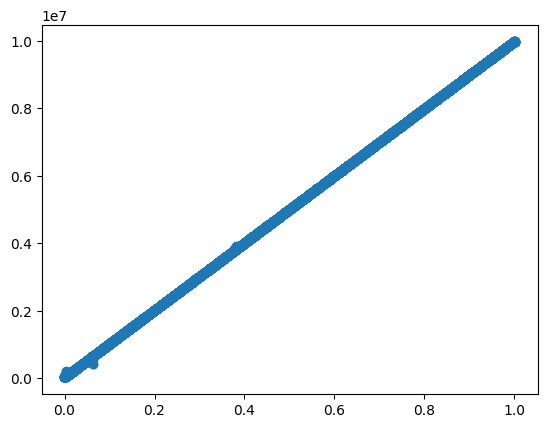

In [37]:
plt.scatter(
    x=X_submission_proc['0'],
    y=X_submission_proc['price']
)

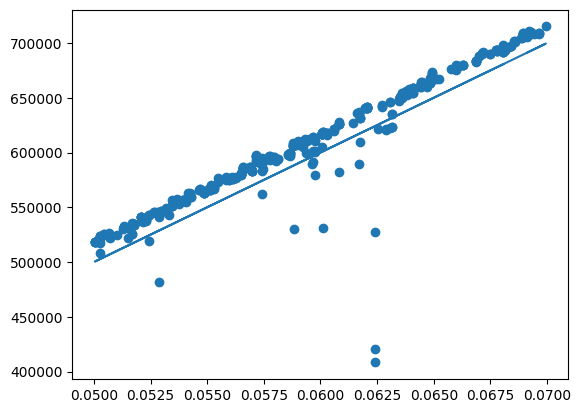

In [38]:
mask = (X_submission_proc['0'] <= 0.07) & (X_submission_proc['0'] > 0.05)
_, ax = plt.subplots()
ax.scatter(
    X_submission_proc.loc[mask]['0'],
    X_submission_proc.loc[mask]['price']
)
ax.plot(
    X_submission_proc.loc[mask]['0'],
    [10000000 * x for x in X_submission_proc.loc[mask]['0']]
)

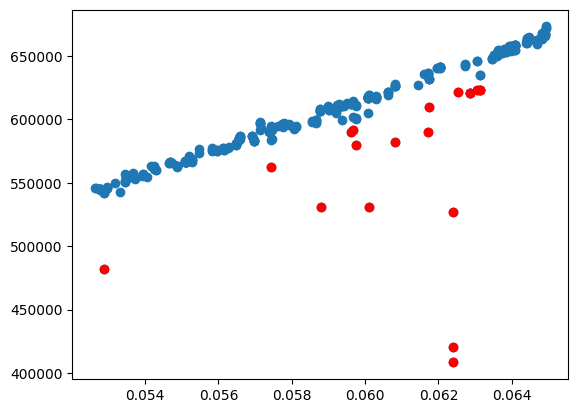

In [39]:
subset = X_submission_proc.loc[
    (X_submission_proc['0'] < 0.0650) &
    (X_submission_proc['0'] > 0.0525)
]

subset_outliers = subset.loc[subset['is_outlier']]


_, ax = plt.subplots()
ax.scatter(subset['0'], subset['price'])
ax.scatter(subset_outliers['0'], subset_outliers['price'], color='red')

In [40]:
prediction_outlier_indices = subset_outliers.head(20).index
prediction_outlier_indices

Int64Index([ 1182,  1944,  2327,  2855,  3163,  3267,  4350,  6750,  6971,
            10096, 10331, 11555, 11640, 12214, 13677, 14269, 14463, 14512,
            15036],
           dtype='int64')

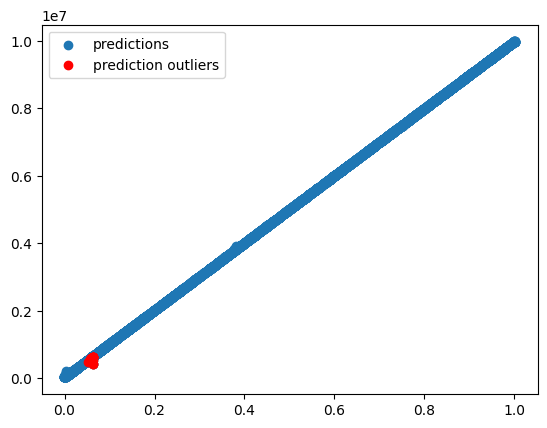

In [41]:
_, ax = plt.subplots()
ax.scatter(
    X_submission['0'],
    predictions,
    label='predictions'
)
ax.scatter(
    X_submission.iloc[prediction_outlier_indices]['0'],
    predictions[prediction_outlier_indices],
    color='red',
    label='prediction outliers'
)
ax.legend()

In [42]:
predictions[prediction_outlier_indices]

array([527202.316, 582250.834, 530598.196, 562319.044, 621037.426,
       530887.98 , 622962.094, 579914.582, 609991.392, 623466.4  ,
       589692.178, 408259.576, 622733.318, 589651.19 , 420499.75 ,
       621658.76 , 482043.734, 620706.654, 591647.872])

In [43]:
predictions[prediction_outlier_indices] = [10000000 * x for x in X_submission_proc.iloc[prediction_outlier_indices]['0']]

In [44]:
predictions[prediction_outlier_indices]

array([623915.42034045, 608267.38085924, 588105.48383537, 574262.98737123,
       628730.20171928, 601145.51673638, 631438.51624487, 597634.73864765,
       617495.71183533, 631438.51624487, 596130.11946676, 623915.42034045,
       630636.05268173, 617194.78799916, 623915.42034045, 625319.73157594,
       528723.1801631 , 628730.20171928, 596832.27508451])

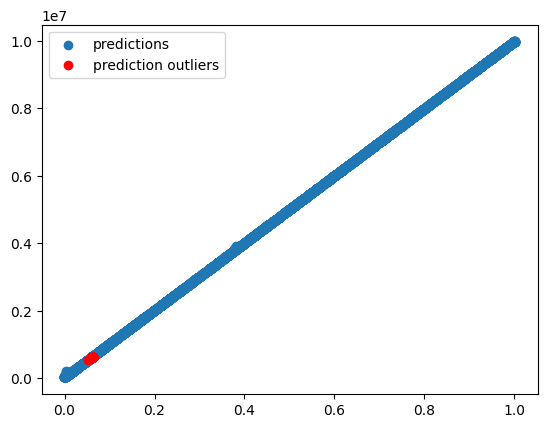

In [45]:
_, ax = plt.subplots()
ax.scatter(
    X_submission['0'],
    predictions,
    label='predictions'
)
ax.scatter(
    X_submission.iloc[prediction_outlier_indices]['0'],
    predictions[prediction_outlier_indices],
    color='red',
    label='prediction outliers'
)
ax.legend()

In [46]:
X_submission_proc

,0,price,is_outlier
0,0.475981,4766145.598,False
1,0.621458,6216840.804,False
2,0.906493,9054964.782,True
3,0.162760,1644866.052,False
4,0.675895,6759288.844,False
...,...,...,...
15149,0.863210,8625330.188,True
15150,0.458979,4598371.968,False
15151,0.736521,7360222.536,True
15152,0.777146,7767610.480,True


In [47]:
pd.DataFrame(
    {
        'id': df_submission.index,
        'price': predictions
    }
).to_csv(
    f'{manager.data_trial_path}/stacking_prediction_postprocessing.csv',
    index=False
)

# Save final model

In [ ]:
manager.save_models(
    {'final_model': final_model}
)

In [ ]:
final_model

StackingRegressor(estimators=[('rf', RandomForestRegressor(n_estimators=200)),
                              ('elastic_net',
                               ElasticNet(alpha=0.5, l1_ratio=1.0,
                                          random_state=255, warm_start=True))],
                  final_estimator=LinearRegression(), verbose=5)